In [1]:
import numpy as np
import xarray as xr
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt

In [2]:
dtrain0 = xr.open_dataset('../Tokyo_Nouken/data/nagoya_train.nc')
dval0 = xr.open_dataset('../Tokyo_Nouken/data/nagoya_val.nc')
dtest0 = xr.open_dataset('../Tokyo_Nouken/data/nagoya_test.nc')
# normalize data 
def datnorm(d): 
    return (d - d.mean()) / d.std() 
# normalize data
dtrain, dval, dtest = datnorm(dtrain0), datnorm(dval0), datnorm(dtest0)
int_data = dtrain['lo'].values
X_train = np.expand_dims(int_data,3)
y_train = dtrain['hi'].values
X_val = np.expand_dims(dval['lo'].values,3)
y_val = dval['hi'].values
X_test = np.expand_dims(dtest['lo'].values,3)
y_test = dtest['hi'].values
print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_validation: ', X_val.shape)
print('Shape of y_validation: ', y_val.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (255, 120, 104, 1)
Shape of y_train:  (255, 120, 104)
Shape of X_validation:  (66, 120, 104, 1)
Shape of y_validation:  (66, 120, 104)
Shape of X_test:  (44, 120, 104, 1)
Shape of y_test:  (44, 120, 104)


In [39]:
# Define the input shape, e.g., 24x32 grayscale images
input_shape = (120, 104, 1)  # (height, width, channels)

# Define the input layer
inputs = Input(shape=input_shape)

# Encoder (Downsampling Path)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Bottleneck
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Decoder (Upsampling Path)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Output layer: single channel for continuous values
outputs = Conv2D(1, (1, 1), activation='linear', padding='same')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mse',  # Mean Squared Error for continuous output
              metrics=['mae'])  # Mean Absolute Error as an additional metric

# Summary of the model architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train, batch_size=8, epochs=50, validation_data=(X_val, y_val))


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 120, 104, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 120, 104, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 120, 104, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 60, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 60, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 60, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 30, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 30, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 30, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_26 (UpSampling2D) │ (None, 60, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 60, 52, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 60, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_27 (UpSampling2D) │ (None, 120, 104, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 120, 104, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 120, 104, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 120, 104, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,241 (727.50 KB)

 Trainable params: 185,601 (725.00 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 437ms/step - loss: 1.5018 - mae: 0.9249 - val_loss: 0.8852 - val_mae: 0.8205
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - loss: 0.6446 - mae: 0.6267 - val_loss: 0.8151 - val_mae: 0.7857
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - loss: 0.2871 - mae: 0.4146 - val_loss: 0.7578 - val_mae: 0.7563
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - loss: 0.2691 - mae: 0.4063 - val_loss: 0.7153 - val_mae: 0.7306
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step - loss: 0.2240 - mae: 0.3704 - val_loss: 0.6476 - val_mae: 0.6950
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - loss: 0.3841 - mae: 0.4729 - val_loss: 0.5764 - val_mae: 0.6559
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - loss: 0.2109 - mae: 0.3623 - val_loss: 0.5142 - val_mae: 0.6194
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - loss: 0.2566 - mae: 0.3945 - val_loss: 0.4787 - val_mae: 0.5933
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/

In [40]:
model.save('cnn1.keras')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 104, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 104, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 120, 104, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 26, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 60, 52, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 52, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 60, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 120, 104, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 120, 104, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 120, 104, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 120, 104, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 741,121 (2.83 MB)

 Trainable params: 739,841 (2.82 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 1.0945 - mae: 0.7909 - val_loss: 0.9225 - val_mae: 0.8309 - learning_rate: 5.0000e-05
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.6054 - mae: 0.6078 - val_loss: 0.8250 - val_mae: 0.7852 - learning_rate: 5.0000e-05
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 0.3353 - mae: 0.4549 - val_loss: 0.7450 - val_mae: 0.7491 - learning_rate: 5.0000e-05
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 0.2832 - mae: 0.4244 - val_loss: 0.6866 - val_mae: 0.7231 - learning_rate: 5.0000e-05
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.2643 - mae: 0.4046 - val_loss: 0.6708 - val_mae: 0.7135 - learning_rate: 5.0000e-05
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 0.1950 - mae: 0.3498 - val_loss: 0.6027 - val_mae: 0.6739 - learning_rate: 5.0000e-05
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.1659 - mae: 0.3235 - val_loss: 0.6136 - val_mae: 0.6762 - learning_ra

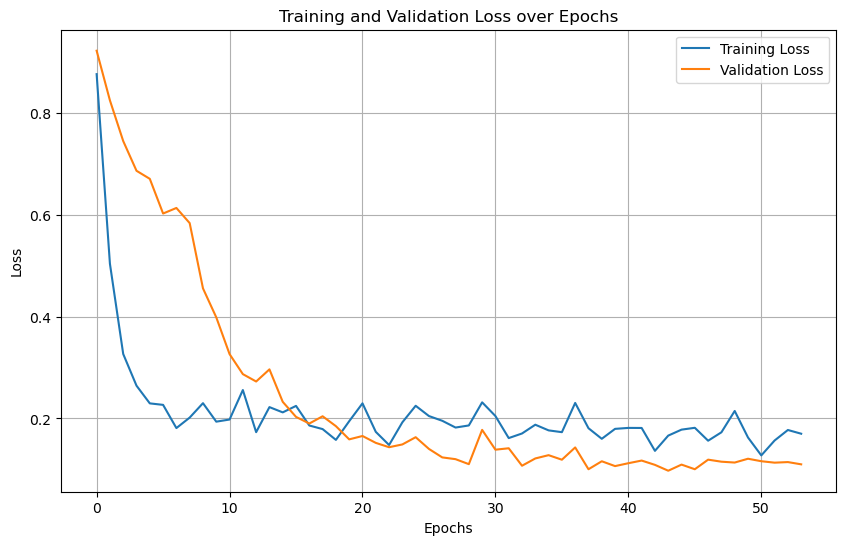

In [4]:
# Define the input shape
input_shape = (120, 104, 1)  # (height, width, channels)

# Define the input layer
inputs = Input(shape=input_shape)

# Encoder (Downsampling Path)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)  # Increased filters
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Increased filters
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

# Bottleneck
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Increased filters
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Decoder (Upsampling Path)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Output layer for continuous values
outputs = Conv2D(1, (1, 1), activation='linear', padding='same')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss='mse',
              metrics=['mae'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Summary of the model architecture
model.summary()

# Train the model with callbacks
history = model.fit(X_train, y_train, batch_size=8, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Plotting the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
model.save('cnn2.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
<xarray.Dataset> Size: 7MB
Dimensions:    (dat: 44, latitude: 120, longitude: 104, date: 44)
Coordinates:
  * latitude   (latitude) float32 480B 34.6 34.61 34.62 ... 35.58 35.59 35.6
  * longitude  (longitude) float32 416B 136.0 136.0 136.0 ... 137.3 137.3 137.3
  * date       (date) datetime64[ns] 352B 2023-01-01 2023-01-07 ... 2023-12-27
Dimensions without coordinates: dat
Data variables:
    pred       (dat, latitude, longitude) float32 2MB 6.766 7.467 ... 6.432
    real       (date, latitude, longitude) float64 4MB 2.3 2.5 2.6 ... 0.3 1.0
<xarray.Dataset> Size: 10MB
Dimensions:    (dat: 66, latitude: 120, longitude: 104, date: 66)
Coordinates:
  * latitude   (latitude) float32 480B 34.6 34.61 34.62 ... 35.58 35.59 35.6
  * longitude  (longitude) float32 416B 136.0 136.0 136.0 ... 137.3 137.3 137.3
  * date       (date) datetime64[ns] 528B 2023-03-22 2023-09-21 ... 2023-09-22
Dimensions without coordinates

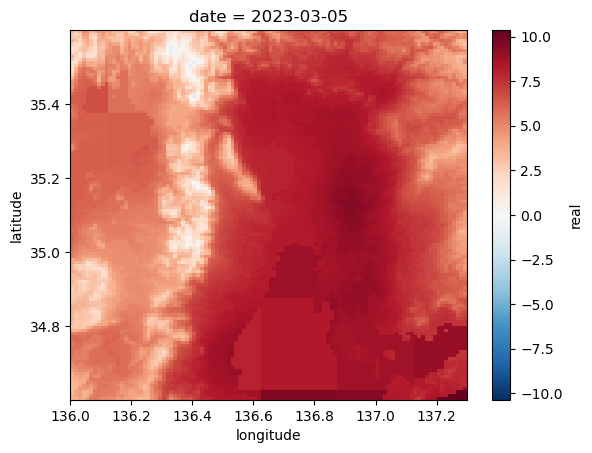

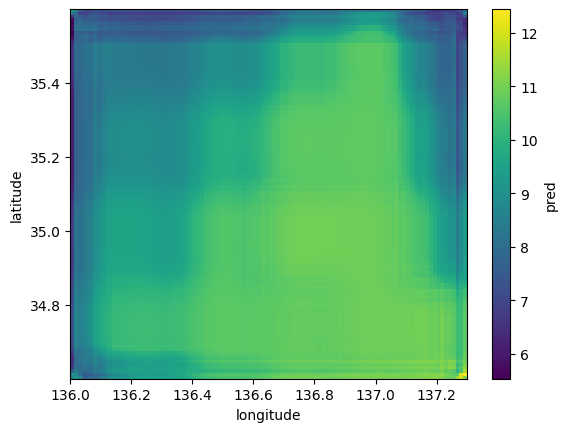

In [8]:
# load model and run
xmodel = tf.keras.models.load_model('cnn1.keras') 
#xmodel = model.
#print(xmodel.summary())

y_pred_val = xmodel.predict(X_val, verbose=1)
y_pred_test = xmodel.predict(X_test, verbose=1) 

# return values to Kelvin 
x1, x2 = dtest0.mean()['hi'], dtest0.std()['hi']
y_pred_test_r = y_pred_test*x2.values + x1.values

x1, x2 = dval0.mean()['hi'], dval0.std()['hi']
y_pred_val_r = y_pred_val*x2.values + x1.values


do = xr.Dataset( )
do['pred'] = ( ('dat', 'latitude', 'longitude'), y_pred_test_r.squeeze())  
do.coords['latitude'] = dtest0.latitude
do.coords['longitude'] = dtest0.longitude
do['real'] = dtest0['hi']

dv = xr.Dataset( )
dv['pred'] = ( ('dat', 'latitude', 'longitude'), y_pred_val_r.squeeze())  
dv.coords['latitude'] = dval0.latitude
dv.coords['longitude'] = dval0.longitude
dv['real'] = dval0['hi']

odir = 'output/'
if not os.path.exists(odir): os.makedirs(odir)
do.to_netcdf(odir+'prediction.nc')
dv.to_netcdf(odir+'validation.nc')
do.close()
dv.close()

#do.pred[0].plot()
#plt.show()
#dtest0['hi'][0].plot()
#plt.show()
#bias = do.pred - dtest0.hi.values
#bias[0].plot()
#print(bias.mean())   

print(do)
print(dv)

do['real'][10].plot()
plt.show()
do['pred'][10].plot()